In [17]:
# Loading in the basics
import psycopg2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from config import password

In [18]:
# Connect to postgres db
ENDPOINT="ucb-data-group-project-zillow.csaw135fqqkl.us-west-1.rds.amazonaws.com"
PORT="5432"
USR="postgres"
REGION="us-west-1"


In [19]:
DBNAME="postgres"

conn = psycopg2.connect(database = DBNAME,
                        user =     USR,
                        password = password,
                        host =     ENDPOINT,
                        port =     PORT)

In [20]:
# list table sql
list_sql = '''
            SELECT *
            FROM list;
            '''
sale_sql = '''
            SELECT *
            FROM sale;
            '''
census_sql = '''
            SELECT *
            FROM census;
            '''

In [60]:
# setting up dfs
list_df = pd.read_sql(list_sql, conn)
sale_df = pd.read_sql(sale_sql, conn)
census_df = pd.read_sql(census_sql, conn)

In [61]:
# general cleaning
list_df = list_df.drop(["region_date","region_id", "region_type"],1)

sale_df = sale_df.drop(["region_date","region_id", "region_type"],1)

list_df.head()

,size_rank,region_name,state_name,date,price
0,0,United States,None,2017-11-04,275448.0
1,1,"New York, NY",NY,2017-11-04,526850.0
2,2,"Los Angeles-Long Beach-Anaheim, CA",CA,2017-11-04,812252.0
3,3,"Chicago, IL",IL,2017-11-04,319556.0
4,4,"Dallas-Fort Worth, TX",TX,2017-11-04,347537.0


In [62]:
city_list = list_df.loc[list_df["region_name"] != "United States"]
city_list = city_list.drop(["state_name"], 1)
city_list = city_list.rename(columns = {"price":"list price"})

city_sale = sale_df.loc[sale_df["region_name"] != "United States"]
city_sale = city_sale.drop(["state_name"], 1)
city_sale = city_sale.rename(columns = {"price":"sale price"})

city_list.head()

,size_rank,region_name,date,list price
1,1,"New York, NY",2017-11-04,526850.0
2,2,"Los Angeles-Long Beach-Anaheim, CA",2017-11-04,812252.0
3,3,"Chicago, IL",2017-11-04,319556.0
4,4,"Dallas-Fort Worth, TX",2017-11-04,347537.0
5,5,"Philadelphia, PA",2017-11-04,263365.0


In [77]:
city_df = city_list.merge(city_sale, on = ["region_name","date"], how = "right")
city_df = city_df.drop(["size_rank_x"],1)
city_df = city_df.rename(columns = {"size_rank_y":"size_rank"})
city_df = city_df.set_index(["date"]).sort_index()
city_df = city_df.dropna()
city_df

,region_name,list price,size_rank,sale price
date,,,,
2017-11-04,"Charlotte, NC",331375.0,24,231809.0
2017-11-04,"Seattle, WA",506536.0,15,441658.0
2017-11-04,"Portland, OR",464833.0,23,368700.0
2017-11-04,"Pittsburgh, PA",181667.0,22,161563.0
2017-11-04,"Baltimore, MD",318469.0,20,284579.0
...,...,...,...,...
2021-05-22,"Orlando, FL",350498.0,27,310360.0
2021-05-22,"San Antonio, TX",303975.0,26,278321.0
2021-05-22,"Charlotte, NC",418826.0,24,324133.0


In [76]:
city_top_ten = city_df.loc[city_df["size_rank"] <= 10]
city_top_fifty = city_df.loc[city_df["size_rank"] <= 50]



,region_name,list price,size_rank,sale price
date,,,,
2008-02-23,"Fort Collins, CO",NaN,159,242350.0
2008-03-01,"Fort Collins, CO",NaN,159,230475.0
2008-03-08,"Fort Collins, CO",NaN,159,231600.0
2008-03-15,"Fort Collins, CO",NaN,159,230475.0
2008-03-22,"Fort Collins, CO",NaN,159,229813.0
...,...,...,...,...
2021-04-24,"Fort Collins, CO",NaN,159,431750.0
2021-05-01,"Fort Collins, CO",NaN,159,435613.0
2021-05-08,"Fort Collins, CO",NaN,159,445613.0


<AxesSubplot:xlabel='date', ylabel='list price'>

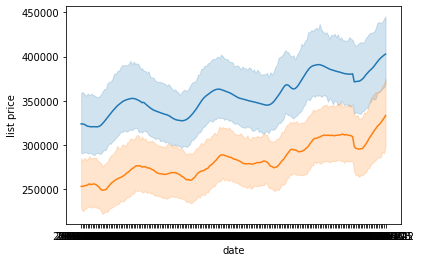

In [82]:
import seaborn as sns
# not a helpful plot, but shows tight relationship of list and sales price on average
sns.lineplot(data=city_df, x="date", y="list price", label = city_df["region_name"], legend = False)
sns.lineplot(data=city_df, x="date", y="sale price", label = city_df["region_name"], legend = False)